In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
data_dir = './data/dtd/'

images_dir = os.path.join(data_dir, 'images')
train_dir = os.path.join(images_dir, 'train')
test_dir = os.path.join(images_dir, 'test')
print(train_dir)

./data/dtd/images\train


In [8]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.5277, 0.4735, 0.4239])
Calculated stds: tensor([0.1801, 0.1818, 0.1784])


In [4]:
pretrained_size = 299
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

In [5]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

In [6]:
print(train_data.classes.__len__())

47


In [7]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [8]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [9]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 3892
Number of validation examples: 433
Number of testing examples: 1315


In [10]:
BATCH_SIZE = 32

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

In [11]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

In [12]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

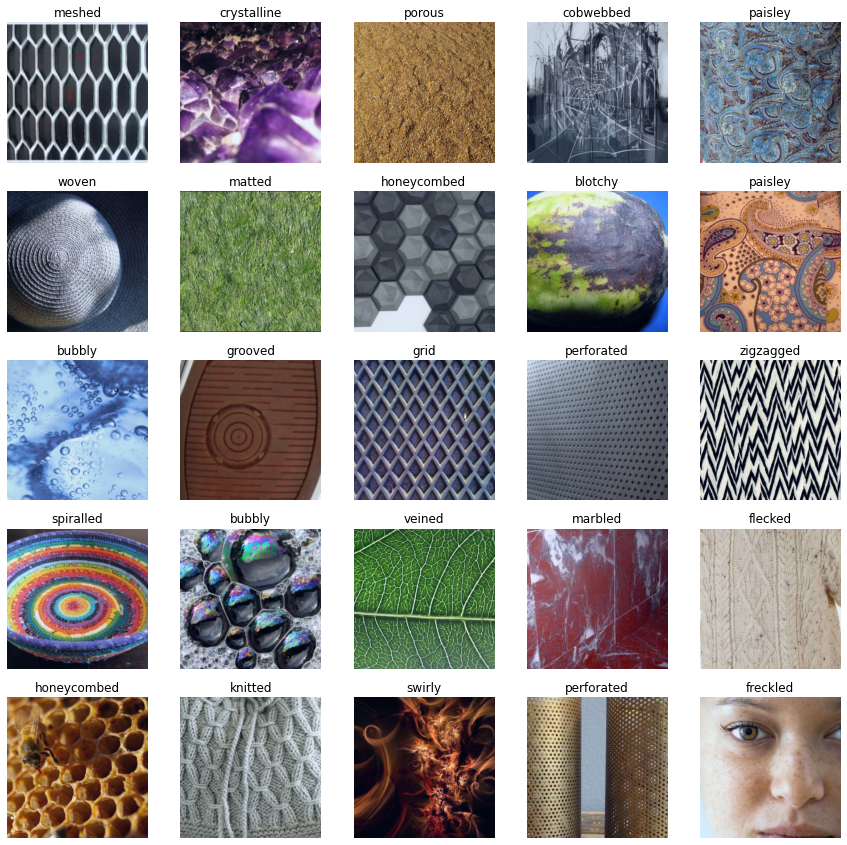

In [18]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

In [19]:
def format_label(label):
    label = label.split('.')[-1]
    label = label.replace('_', ' ')
    label = label.title()
    label = label.replace(' ', '')
    return label

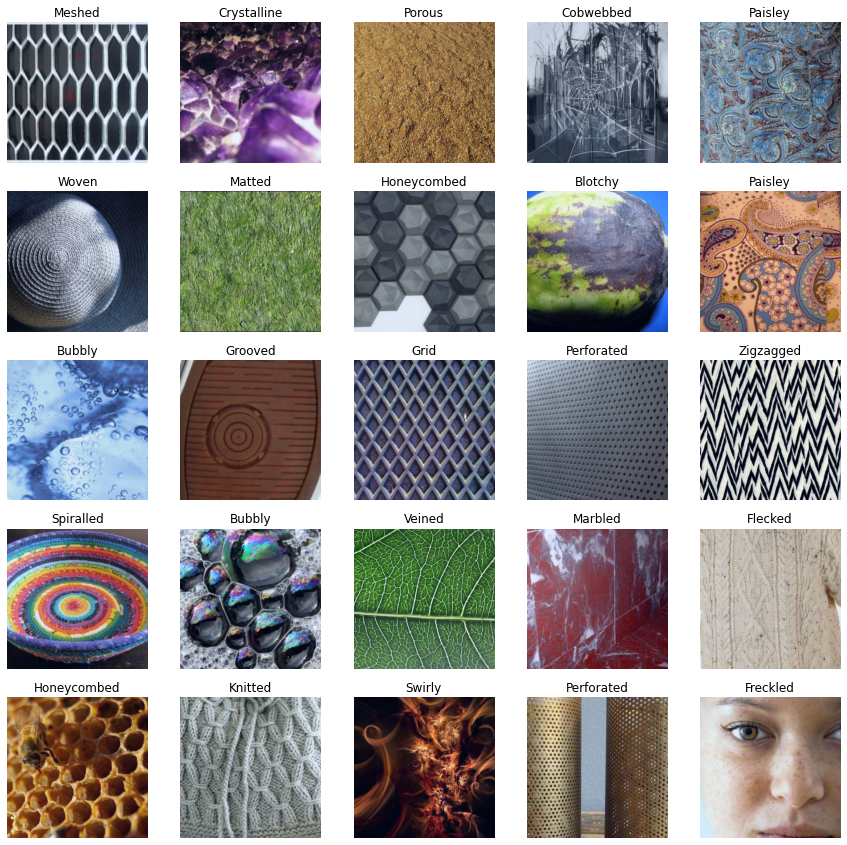

In [20]:
test_data.classes = [format_label(c) for c in test_data.classes]

classes = test_data.classes

plot_images(images, labels, classes)

In [13]:
class BasicConv2d(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, bias=False) # verify bias false
        self.bn = nn.BatchNorm2d(out_planes,
                                 eps=0.001, # value found in tensorflow
                                 momentum=0.1, # default pytorch value
                                 affine=True)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Mixed_3a(nn.Module):

    def __init__(self):
        super(Mixed_3a, self).__init__()
        self.maxpool = nn.MaxPool2d(3, stride=2)
        self.conv = BasicConv2d(64, 96, kernel_size=3, stride=2)

    def forward(self, x):
        x0 = self.maxpool(x)
        x1 = self.conv(x)
        out = torch.cat((x0, x1), 1)
        return out


class Mixed_4a(nn.Module):

    def __init__(self):
        super(Mixed_4a, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv2d(160, 64, kernel_size=1, stride=1),
            BasicConv2d(64, 96, kernel_size=3, stride=1)
        )

        self.branch1 = nn.Sequential(
            BasicConv2d(160, 64, kernel_size=1, stride=1),
            BasicConv2d(64, 64, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(64, 64, kernel_size=(7,1), stride=1, padding=(3,0)),
            BasicConv2d(64, 96, kernel_size=(3,3), stride=1)
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        return out


class Mixed_5a(nn.Module):

    def __init__(self):
        super(Mixed_5a, self).__init__()
        self.conv = BasicConv2d(192, 192, kernel_size=3, stride=2)
        self.maxpool = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.conv(x)
        x1 = self.maxpool(x)
        out = torch.cat((x0, x1), 1)
        return out


class Inception_A(nn.Module):

    def __init__(self):
        super(Inception_A, self).__init__()
        self.branch0 = BasicConv2d(384, 96, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(384, 64, kernel_size=1, stride=1),
            BasicConv2d(64, 96, kernel_size=3, stride=1, padding=1)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(384, 64, kernel_size=1, stride=1),
            BasicConv2d(64, 96, kernel_size=3, stride=1, padding=1),
            BasicConv2d(96, 96, kernel_size=3, stride=1, padding=1)
        )

        self.branch3 = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False),
            BasicConv2d(384, 96, kernel_size=1, stride=1)
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Reduction_A(nn.Module):

    def __init__(self):
        super(Reduction_A, self).__init__()
        self.branch0 = BasicConv2d(384, 384, kernel_size=3, stride=2)

        self.branch1 = nn.Sequential(
            BasicConv2d(384, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 224, kernel_size=3, stride=1, padding=1),
            BasicConv2d(224, 256, kernel_size=3, stride=2)
        )

        self.branch2 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        return out


class Inception_B(nn.Module):

    def __init__(self):
        super(Inception_B, self).__init__()
        self.branch0 = BasicConv2d(1024, 384, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(1024, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 224, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(224, 256, kernel_size=(7,1), stride=1, padding=(3,0))
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(1024, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 192, kernel_size=(7,1), stride=1, padding=(3,0)),
            BasicConv2d(192, 224, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(224, 224, kernel_size=(7,1), stride=1, padding=(3,0)),
            BasicConv2d(224, 256, kernel_size=(1,7), stride=1, padding=(0,3))
        )

        self.branch3 = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False),
            BasicConv2d(1024, 128, kernel_size=1, stride=1)
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Reduction_B(nn.Module):

    def __init__(self):
        super(Reduction_B, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv2d(1024, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 192, kernel_size=3, stride=2)
        )

        self.branch1 = nn.Sequential(
            BasicConv2d(1024, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 256, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(256, 320, kernel_size=(7,1), stride=1, padding=(3,0)),
            BasicConv2d(320, 320, kernel_size=3, stride=2)
        )

        self.branch2 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        return out


class Inception_C(nn.Module):

    def __init__(self):
        super(Inception_C, self).__init__()

        self.branch0 = BasicConv2d(1536, 256, kernel_size=1, stride=1)

        self.branch1_0 = BasicConv2d(1536, 384, kernel_size=1, stride=1)
        self.branch1_1a = BasicConv2d(384, 256, kernel_size=(1,3), stride=1, padding=(0,1))
        self.branch1_1b = BasicConv2d(384, 256, kernel_size=(3,1), stride=1, padding=(1,0))

        self.branch2_0 = BasicConv2d(1536, 384, kernel_size=1, stride=1)
        self.branch2_1 = BasicConv2d(384, 448, kernel_size=(3,1), stride=1, padding=(1,0))
        self.branch2_2 = BasicConv2d(448, 512, kernel_size=(1,3), stride=1, padding=(0,1))
        self.branch2_3a = BasicConv2d(512, 256, kernel_size=(1,3), stride=1, padding=(0,1))
        self.branch2_3b = BasicConv2d(512, 256, kernel_size=(3,1), stride=1, padding=(1,0))

        self.branch3 = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False),
            BasicConv2d(1536, 256, kernel_size=1, stride=1)
        )

    def forward(self, x):
        x0 = self.branch0(x)

        x1_0 = self.branch1_0(x)
        x1_1a = self.branch1_1a(x1_0)
        x1_1b = self.branch1_1b(x1_0)
        x1 = torch.cat((x1_1a, x1_1b), 1)

        x2_0 = self.branch2_0(x)
        x2_1 = self.branch2_1(x2_0)
        x2_2 = self.branch2_2(x2_1)
        x2_3a = self.branch2_3a(x2_2)
        x2_3b = self.branch2_3b(x2_2)
        x2 = torch.cat((x2_3a, x2_3b), 1)

        x3 = self.branch3(x)

        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class InceptionV4(nn.Module):

    def __init__(self, num_classes=1001):
        super(InceptionV4, self).__init__()
        # Special attributs
        self.input_space = None
        self.input_size = (299, 299, 3)
        self.mean = None
        self.std = None
        # Modules
        self.features = nn.Sequential(
            BasicConv2d(3, 32, kernel_size=3, stride=2),
            BasicConv2d(32, 32, kernel_size=3, stride=1),
            BasicConv2d(32, 64, kernel_size=3, stride=1, padding=1),
            Mixed_3a(),
            Mixed_4a(),
            Mixed_5a(),
            Inception_A(),
            Inception_A(),
            Inception_A(),
            Inception_A(),
            Reduction_A(), # Mixed_6a
            Inception_B(),
            Inception_B(),
            Inception_B(),
            Inception_B(),
            Inception_B(),
            Inception_B(),
            Inception_B(),
            Reduction_B(), # Mixed_7a
            Inception_C(),
            Inception_C(),
            Inception_C()
        )
        self.last_linear = nn.Linear(1536, num_classes)

    def logits(self, features):
        #Allows image of any size to be processed
        adaptiveAvgPoolWidth = features.shape[2]
        x = F.avg_pool2d(features, kernel_size=adaptiveAvgPoolWidth)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, input):
        x = self.features(input)
        x = self.logits(x)
        return x


def inceptionv4(num_classes=1000, pretrained='imagenet'):
    if pretrained:
        settings = pretrained_settings['inceptionv4'][pretrained]
        assert num_classes == settings['num_classes'], \
            "num_classes should be {}, but is {}".format(settings['num_classes'], num_classes)

        # both 'imagenet'&'imagenet+background' are loaded from same parameters
        model = InceptionV4(num_classes=1001)
        model.load_state_dict(model_zoo.load_url(settings['url']))

        if pretrained == 'imagenet':
            new_last_linear = nn.Linear(1536, 1000)
            new_last_linear.weight.data = model.last_linear.weight.data[1:]
            new_last_linear.bias.data = model.last_linear.bias.data[1:]
            model.last_linear = new_last_linear

        model.input_space = settings['input_space']
        model.input_size = settings['input_size']
        model.input_range = settings['input_range']
        model.mean = settings['mean']
        model.std = settings['std']
    else:
        model = InceptionV4(num_classes=num_classes)
    return model

In [15]:
pretrained_settings = {
    'inceptionv4': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/inceptionv4-8e4777a0.pth',
            'input_space': 'RGB',
            'input_size': [3, 299, 299],
            'input_range': [0, 1],
            'mean': [0.5, 0.5, 0.5],
            'std': [0.5, 0.5, 0.5],
            'num_classes': 1000
        },
        'imagenet+background': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/inceptionv4-8e4777a0.pth',
            'input_space': 'RGB',
            'input_size': [3, 299, 299],
            'input_range': [0, 1],
            'mean': [0.5, 0.5, 0.5],
            'std': [0.5, 0.5, 0.5],
            'num_classes': 1001
        }
    }
}

# Find best LR

In [17]:
START_LR = 1e-7

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

pretrained_model = inceptionv4(num_classes=47, pretrained=None).to(device)
model = pretrained_model

optimizer = optim.Adam(model.parameters(), lr=START_LR)

criterion = nn.CrossEntropyLoss()

criterion = criterion.to(device)

cuda


In [18]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [19]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 8.00 GiB total capacity; 7.21 GiB already allocated; 0 bytes free; 7.32 GiB reserved in total by PyTorch)

In [6]:
# Hyperparameters
n_output=1
# Number of Epochs
num_epochs = 20
# Learning Rate
learning_rate = 0.01
# Model parameters

# Show stats for every n number of batches
show_every_n_batches = 1

In [7]:
def train_rnn(model, batch_size, optimizer, criterion, n_epochs, show_every_n_batches=100):
    train_loss = 0
    valid_loss = 0
    batch_losses = []
    val_batch_losses = []
    valid_loss_min = np.Inf
    
    model.train()
    
    previousLoss = np.Inf
    minLoss = np.Inf

    print("Training for %d epoch(s)..." % n_epochs)
    for epoch_i in range(1, n_epochs + 1):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            #print(batch_idx + len(train_loader.dataset))
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            target = np.squeeze(target)
            #target = target.view(1,-1)
            target= target.long()
            #print(np.squeeze(target))
            #targs = target.view(-1).long()
            optimizer.zero_grad()
            # forward pass: Train compute predicted outputs by passing inputs to the model
            output = model.forward(data)
            output, _ = output
            #print(output.squeeze(1))
            #print(target)
            target = torch.max(target, 1)[1] + 1
            #_, preds = torch.max(output.data, 1)
            #loss = criterion(output, torch.max(target, 1)[1])
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            #print(loss)
            # update training loss
            ## find the loss and update the model parameters accordingly       
            train_loss += loss.item()
            #print(loss.item())
            
        model.eval()
        for batch_idx, (data, target) in enumerate(val_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            target = np.squeeze(target)
            target= target.long()
            #target = target.view(1,-1)
            target = torch.max(target, 1)[1] + 1
            output = model.forward(data)
            #print(output)
            #print(target)
            #output, _ = output
            # calculate the Val batch loss
            #loss = criterion(output, torch.max(target, 1)[1])
            loss = criterion(output, target)
            # update average validation loss 
            #val_batch_losses.append(loss.item())
            #valid_loss += ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            valid_loss += loss.item()
            #print(loss.item())
        
        valid_loss = valid_loss/len(val_loader.dataset)
        train_loss = train_loss/len(train_loader.dataset)
        
        # print training/validation statistics 
        if epoch_i%show_every_n_batches == 0:
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch_i, train_loss, valid_loss))
        
            ## TODO: save the model if validation loss has decreased
            # save model if validation loss has decreased
            if valid_loss < valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
                with open('trained_rnn_new', 'wb') as pickle_file:
                    torch.save(model.state_dict(), 'save/trained_rnn_new')
                valid_loss_min = valid_loss
                train_loss = 0
                valid_loss = 0
                #batch_losses = []
                #val_batch_losses = []
  
    return model

In [8]:
model_transfer = models.inception_v3(pretrained=True)
print(model_transfer)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [9]:
# Freeze training for all "features" layers
#for param in model_transfer.features.parameters():
    #param.requires_grad = False

## Freezing all layers
for params in model_transfer.parameters():
    params.requires_grad = False

## Freezing the first few layers. Here I am freezing the first 7 layers 
        
custom_model = nn.Sequential(nn.Linear(2048, 1024), 
                  nn.PReLU(),
                  nn.Dropout(p=0.25), 
                  nn.Linear(1024, 102)
                 )

if use_cuda:
    custom_model = custom_model.to(device)
    
model_transfer.fc = custom_model
#model_transfer.classifier = custom_model
decay_rate = learning_rate / num_epochs

#model_transfer.load_state_dict(torch.load('save/trained_rnn_new'))

if use_cuda:
    model_transfer = model_transfer.cuda()

# print(model_transfer)

# specify loss function
#criterion_scratch = nn.CrossEntropyLoss()
criterion_scratch = nn.BCELoss()
#criterion_scratch = nn.BCELoss(reduction="mean").to('cuda:0')

# specify optimizer
optimizer_scratch = optim.SGD(model_transfer.parameters(), lr=learning_rate, momentum=0.9, weight_decay=decay_rate)
#optimizer_scratch = optim.Adam(model_transfer.classifier.parameters(), lr=learning_rate)
#optimizer_scratch = optim.SGD(list(filter(lambda p: p.requires_grad, model_transfer.parameters())), lr=learning_rate, momentum=0.9)


trained_rnn = train_rnn(model_transfer, batch_size, optimizer_scratch, criterion_scratch, num_epochs, show_every_n_batches)

Training for 20 epoch(s)...


/home/koushik/.conda/envs/deep-learning/lib/python3.7/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 102])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


ValueError: Target and input must have the same number of elements. target nelement (32) != input nelement (3264)

In [ ]:
model_transfer.load_state_dict(torch.load('save/trained_rnn_new'))
model_transfer.eval()

In [ ]:
from sklearn.metrics import r2_score

preds = []
targetpred = []
for batch_idx, (data, target) in enumerate(test_val_loader):
    # move to GPU
    #print(np.squeeze(target.detach().cpu().numpy()))
    if use_cuda:
        data, target = data.cuda(), target.cuda()
    ## update the average validation loss
    # forward pass: compute predicted outputs by passing inputs to the model
    #target= target.long()
    output = model_transfer.forward(data)
    output = np.squeeze(output.detach().cpu().numpy())
    target = np.squeeze(target.detach().cpu().numpy())
    #print(torch.max(target, 0))
    #print(np.argmax(target))
    #print(np.argmax(output))
    #print(torch.max(output, 1)[1].detach().cpu().numpy())
    #values, indices = output.max(1)    
    output = np.argmax(output)
    target = np.argmax(target)
    #print(tpr)
    preds.append(int(output))
    targetpred.append(int(target) + 1)
    #print(pr.detach().cpu())
print(preds[:100])
print(targetpred[:100])
r2_score(targetpred, preds)

In [ ]:
preds = []
np.set_printoptions(threshold=100)
submission = pd.read_csv('sample_submission.csv')
for batch_idx, (data, target) in enumerate(test_loader):
    # move to GPU
    #print(np.squeeze(target.detach().cpu().numpy()))
    if use_cuda:
        data, target = data.cuda(), target.cuda()
    ## update the average validation loss
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model_transfer.forward(data)
    #print(target)
    #print(output)
    #print(torch.max(output, 1)[1].detach().cpu().numpy())
    #values, indices = output.max(1)    
    pr = torch.max(output, 1)[1].detach().cpu().numpy()
    preds.append(int(pr[0]) + 1)
    #for i in pr:
        #preds.append(i)
    #print(batch_idx)
    #print(pr)
    #print(x.argsort()[-6:][::-1])
    #print(pr.argsort()[-6:][::-1])
    #print(values)
    # calculate the batch loss
submission["category"] = preds
print(submission.head())


In [ ]:
submission.to_csv('submission.csv', index=False)